In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Импортируем необходимые библиотеки.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from collections import Counter


import plotly.express as px
import category_encoders as ce
from sklearn import preprocessing

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Загружаем инструмент для разбивки данных:
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/GrachyaDarbinyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# фиксируем RANDOM_SEED и версию пакетов
RANDOM_SEED = 42
!pip freeze > requirements.tx

In [4]:
# данные из соревнования

df_train = pd.read_csv('hotels_train.csv') 
df_test = pd.read_csv('hotels_test.csv') 
sample_submission = pd.read_csv('submission.csv')

In [5]:
# объединяем датафреймы
df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['reviewer_score'] = 0 
df = df_test.append(df_train, sort=False).reset_index(drop=True) 

/var/folders/ps/3ff5987d7r78lx_0yrbr9srh0000gn/T/ipykernel_19759/4264704249.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_test.append(df_train, sort=False).reset_index(drop=True)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [7]:
df.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


### Адрес отеля.

Из адреса отеля по факту полезную информацию может нести город. Извлечем этот признак.

In [8]:
df['hotel_address']

0                        Via Senigallia 6 20161 Milan Italy
1         Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2               Mallorca 251 Eixample 08008 Barcelona Spain
3         Piazza Della Repubblica 17 Central Station 201...
4         Singel 303 309 Amsterdam City Center 1012 WJ A...
                                ...                        
515733    9 Knaresborough Place Kensington and Chelsea L...
515734    Landstra er Hauptstra e 155 03 Landstra e 1030...
515735    29 31 Gower Street Camden London WC1E 6HG Unit...
515736    31 Great Cumberland Place Westminster Borough ...
515737    25 Courtfield Gardens Kensington and Chelsea L...
Name: hotel_address, Length: 515738, dtype: object

In [9]:
df['hotel_city'] = df['hotel_address'].apply(lambda x: x.split()[-2] if x.split()[-2] != 'United' 
                                             else x.split()[-5]) # город - предпоследнее слово, за исключением UK


In [10]:
df =  df.drop(['hotel_address'], axis = 1) # удаляем оставшуюся информацию об адресах

In [11]:
df['hotel_city'].unique()

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

Признаков городов не так много. Можно поделить их на два типа категории - по климату и значению(столица или нет). Можем выделить информацию о столице.
Один город также имеет свою особенность (наличие морского пляжа) - это Барселона. Это важная деталь для туристических поездок.
Выделим эту информацию.

In [12]:
df['sea_side'] = df['hotel_city'].apply(lambda x: 1 if x == 'Barcelona' else 0)

Также выделим информацию о столице, так как уникальных значений мало, это довольно-таки легко.

In [13]:
df['is_capital'] = df['hotel_city'].apply(lambda x: 1 if x == ['Amsterdam','London', 'Paris', 'Vienna'] else 0)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

### Координаты. Пропуски.

Мы видим, что пропуски есть в данных по координатам и их одинаковое количество. То есть это строчки, где пропущены обе координаты.

Целесообразно заполнять пропуски в координатах модальным значением в зависимости от города.

In [15]:
list_city = ('Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna')

In [16]:
# создаем словари для модальных значений координат в зависимости от города
lat_dict = {}
lng_dict = {}

for city in list_city:
    lat_dict[city] = lat_dict.get(city, df[df['hotel_city']==city]['lat'].mode()[0])
    lng_dict[city] = lng_dict.get(city, df[df['hotel_city']==city]['lng'].mode()[0])

In [17]:
# бежим циклом по списку городов и ищем индексы с нулевыми значениям
for city in list_city:
    df.loc[(df['lat'].isnull() & (df['hotel_city'] == city)), 'lat'] = lat_dict[city]
    df.loc[(df['lng'].isnull() & (df['hotel_city'] == city)), 'lng'] = lng_dict[city]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

Преобразуем признак days_since_review в числовой.

In [19]:
df['days_since_review'] = df['days_since_review'].apply(lambda x: int(x.split()[0]))

In [20]:
df.head()

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_city,sea_side,is_capital
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13,45.533137,9.171102,0,0.0,Milan,0,0
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234,52.385649,4.834443,0,0.0,Amsterdam,0,0
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616,41.393192,2.161520,0,0.0,Barcelona,1,0
3,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656,45.479888,9.196298,0,0.0,Milan,0,0
4,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444,52.370545,4.888644,0,0.0,Amsterdam,0,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

In [22]:
# преобразуем признак review_date в тип данных дата

df['review_date'] = pd.to_datetime(df['review_date'])

In [23]:
df['review_date']

0        2017-07-21
1        2016-12-12
2        2015-11-26
3        2015-10-17
4        2016-05-16
            ...    
515733   2017-04-19
515734   2017-02-13
515735   2016-02-07
515736   2017-05-21
515737   2016-08-05
Name: review_date, Length: 515738, dtype: datetime64[ns]

### Дата.

Вытащим из даты день, месяц и год.

In [24]:
df['review_month'] = df['review_date'].dt.month
df['review_dayofweek'] = df['review_date'].dt.dayofweek
df['review_year'] = df['review_date'].dt.year

Также обращаю внимание, что может быть зависимость от того, выходной день или нет.

In [25]:
df['is_day_off'] = df['review_dayofweek'].apply(lambda x: 1 if x > 5 else 0)
df = df.drop(['review_dayofweek'], axis=1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   hotel_name                                  515738 non-null  object        
 4   reviewer_nationality                        515738 non-null  object        
 5   negative_review                             515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

In [27]:
df = df.drop(['review_date'], axis = 1) #Теперь столбец review_date можем удалить

### Тэги. Количество ночей.

Изучив признак tags выясняется, что в них описываются 4 других признака: цель поездки, количество отдыхающих, тип номера в отеле и количество проведенных ночей. Вытащим эти признаки.

In [28]:
# напишем функцию, которая превратит строку тэгов в список для удобства работы

def tags_to_list(tags_string): 
    tags_list = tags_string[1:-3].replace("' ", "").split(" ', ")
    return tags_list

df['tags_list'] = df['tags'].apply(tags_to_list)


In [29]:
# напишем функцию, которая вытащимт признак, определяющий количество проведенных в отеле ночей

def get_nights(tags_list):
    nights = []
    for i in tags_list:
        if ' night' in i:
            nights.append(i)
    return ' '.join(nights)

df['nights_count'] = df['tags_list'].apply(get_nights)

In [30]:
df['nights_count'].unique()

array(['Stayed 2 nights', 'Stayed 1 night', 'Stayed 3 nights',
       'Stayed 4 nights', 'Stayed 7 nights', 'Stayed 5 nights',
       'Stayed 6 nights', 'Stayed 14 nights', 'Stayed 12 nights',
       'Stayed 8 nights', 'Stayed 9 nights', '', 'Stayed 13 nights',
       'Stayed 10 nights', 'Stayed 11 nights', 'Stayed 18 nights',
       'Stayed 16 nights', 'Stayed 25 nights', 'Stayed 15 nights',
       'Stayed 19 nights', 'Stayed 23 nights', 'Stayed 26 nights',
       'Stayed 17 nights', 'Stayed 21 nights',
       'Special Offer Double Room 3 nights minimum Stayed 2 nights',
       'Stayed 24 nights', 'Stayed 29 nights', 'Stayed 20 nights',
       'Stayed 22 nights', 'Stayed 31 nights',
       'Special Offer Double Room 3 nights minimum Stayed 1 night',
       'Stayed 27 nights', 'Stayed 30 nights',
       'Special Offer Double Room 3 nights minimum Stayed 5 nights',
       'Special Offer Double Room 3 nights minimum Stayed 3 nights',
       'Stayed 28 nights',
       'Junior Suite Give m

Мы видим что есть особенные тэги, которые выбиваются из привычного Stayed ... nights

In [31]:
df['nights_count'] = df['nights_count'].apply(lambda x: x.split(' '))

In [32]:
# напишем функцию для обработки выбивающихся из общего ряда тэгов 
# (в них есть числа, поэтому просто вытаскивание чисел приведет к ложному результату)
def tags_nights(nights_count_tag):
    for i in nights_count_tag:
        if 'Special' in i:
            return nights_count_tag[-3::]
        elif 'Junior' in i:
            return nights_count_tag[-3::]
        else:
            return nights_count_tag
   
df['nights_count'] = df['nights_count'].apply(tags_nights) 

In [33]:
df['nights_count']

0         [Stayed, 2, nights]
1          [Stayed, 1, night]
2          [Stayed, 1, night]
3          [Stayed, 1, night]
4         [Stayed, 2, nights]
                 ...         
515733    [Stayed, 2, nights]
515734    [Stayed, 4, nights]
515735     [Stayed, 1, night]
515736    [Stayed, 2, nights]
515737    [Stayed, 4, nights]
Name: nights_count, Length: 515738, dtype: object

In [34]:
df['nights_count'] = df['nights_count'].apply(lambda x: ' '.join(x))
df['nights_count'].unique()

array(['Stayed 2 nights', 'Stayed 1 night', 'Stayed 3 nights',
       'Stayed 4 nights', 'Stayed 7 nights', 'Stayed 5 nights',
       'Stayed 6 nights', 'Stayed 14 nights', 'Stayed 12 nights',
       'Stayed 8 nights', 'Stayed 9 nights', '', 'Stayed 13 nights',
       'Stayed 10 nights', 'Stayed 11 nights', 'Stayed 18 nights',
       'Stayed 16 nights', 'Stayed 25 nights', 'Stayed 15 nights',
       'Stayed 19 nights', 'Stayed 23 nights', 'Stayed 26 nights',
       'Stayed 17 nights', 'Stayed 21 nights', 'Stayed 24 nights',
       'Stayed 29 nights', 'Stayed 20 nights', 'Stayed 22 nights',
       'Stayed 31 nights', 'Stayed 27 nights', 'Stayed 30 nights',
       'Stayed 28 nights'], dtype=object)

In [35]:
df['nights_count'].mode()

0    Stayed 1 night
Name: nights_count, dtype: object

Мы видим что есть строки, в которых нет никакой информации о количество проведенных ночей в отеле. Так как их мало, есть смысл заполнить эти пропуски модальным значением.

In [36]:
df[df['nights_count']== '']['tags']

703       [' Leisure trip ', ' Couple ', ' Submitted fro...
928       [' Leisure trip ', ' Solo traveler ', ' Submit...
3557                  [' Leisure trip ', ' Solo traveler ']
3796                  [' Leisure trip ', ' Solo traveler ']
7012      [' Leisure trip ', ' Group ', ' Submitted from...
                                ...                        
504026                       [' Leisure trip ', ' Couple ']
509298                                         [' Couple ']
511279                        [' Leisure trip ', ' Group ']
513297    [' Leisure trip ', ' Couple ', ' Submitted fro...
513878                      [' Business trip ', ' Couple ']
Name: tags, Length: 192, dtype: object

In [37]:
df['nights_count'] = df['nights_count'].apply(lambda x: x.split(' '))

In [38]:
def fill_not_missed(nights):
    for i in nights:
        if 'Stayed' in i:
            return nights[1]
        else:
            return '1'

In [39]:
df['nights_count'] = df['nights_count'].apply(fill_not_missed)

In [40]:
df['nights_count'] = df['nights_count'].apply(lambda x: ''.join(x))
df['nights_count'].unique() # для проверки

array(['2', '1', '3', '4', '7', '5', '6', '14', '12', '8', '9', '13',
       '10', '11', '18', '16', '25', '15', '19', '23', '26', '17', '21',
       '24', '29', '20', '22', '31', '27', '30', '28'], dtype=object)

In [41]:
# наконец-то преобразуем в числовой тип данных
df['nights_count'] = df['nights_count'].astype('int64')

ура!

### Тэги. Анализируем информацию.

Мы можем посмотреть, какие тэги встречаются чаще всего, а какие реже.

<AxesSubplot:ylabel='Tag'>

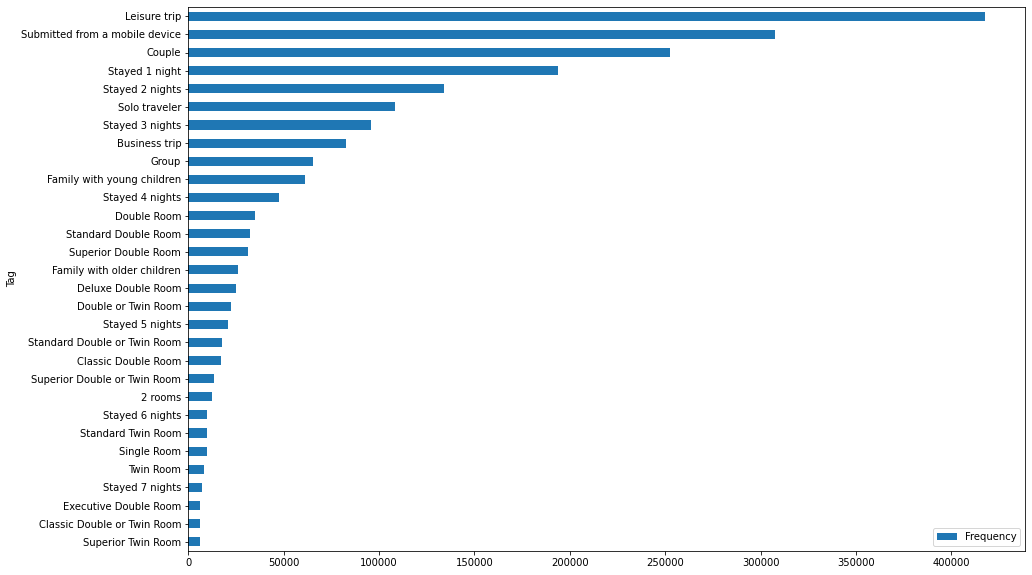

In [42]:

cnt = Counter()

for i, row in df['tags'].items():
    tmp = row[3:-3].split(" ', ' ")
    cnt.update(tmp)

top_tags = cnt.most_common(30)

plt.rcParams['figure.figsize'] = (15,10)
data = pd.DataFrame(top_tags, columns =['Tag', 'Frequency'])
data.sort_values(by='Frequency', inplace = True)
data.plot(x='Tag', kind='barh')

Важно! Больше всего туристических поездок. Чаще всего путешествуют вдвоем и на 1-2 ночи.

Мы выбрали 30 самых частых тэгов. Вытащу самые важные из них.

In [43]:
def leisure(tags_list):
    for i in tags_list:
        if 'Leisure' in i:
            return 1
        else:
            return 0

In [44]:
df['if_leisure'] = df['tags_list'].apply(leisure)

In [45]:
df['if_leisure']

0         1
1         1
2         0
3         1
4         0
         ..
515733    1
515734    1
515735    0
515736    1
515737    1
Name: if_leisure, Length: 515738, dtype: int64

In [46]:
def mobile_device(tags_list):
    for i in tags_list:
        if 'mobile' in i:
            return 1
        else:
            return 0

In [47]:
df['if_mobile_device'] = df['tags_list'].apply(mobile_device)

In [48]:
df = df.drop(['tags','tags_list'], axis = 1)

### Отзывы. Проектирование нового признака.

Мы можем посчитать сколько в процентах в отзыве позитивных и негативных слов(интонаций).

In [49]:
df['positive_words_percent'] = df['review_total_positive_word_counts'] / (df['review_total_positive_word_counts'] + df['review_total_negative_word_counts'])
df['negative_words_percent'] = df['review_total_negative_word_counts'] / (df['review_total_positive_word_counts'] + df['review_total_negative_word_counts'])

df.head()

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,sea_side,is_capital,review_month,review_year,is_day_off,nights_count,if_leisure,if_mobile_device,positive_words_percent,negative_words_percent
0,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,0,0,7,2017,0,2,1,0,0.54386,0.45614
1,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,0,0,12,2016,0,1,1,0,0.00000,1.00000
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,...,1,0,11,2015,0,1,0,0,0.62500,0.37500
3,241,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,...,0,0,10,2015,0,1,1,0,1.00000,0.00000
4,834,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,...,0,0,5,2016,0,2,0,0,1.00000,0.00000


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

В последних столбцах positive_words_percent и negative_words_percent есть пропуски. Предполагаю что это те отзывы, где были какие-то нулевые значения. Поэтоме принимаю решение заполнить нулями.

In [51]:
values = {'positive_words_percent': 0, 'negative_words_percent': 0}
df = df.fillna(values)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

### Национальность.

In [53]:
df['reviewer_nationality'].value_counts()

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

Мы видим, что есть национальности, которые представлены 1 раз. Мы можем оставить те, что больше всего встречаются.

In [54]:
nationalities = list(df['reviewer_nationality'].value_counts()[:10].index)
df['reviewer_nationality'] = df['reviewer_nationality'].apply(lambda x: x if x in nationalities else 'other')

### Название отеля.

In [55]:
df['hotel_name'].value_counts()

Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
                                                     ... 
Hotel Eitlj rg                                         12
Hotel Daniel Paris                                     12
Mercure Paris Porte d Orleans                          10
Hotel Wagner                                           10
Hotel Gallitzinberg                                     8
Name: hotel_name, Length: 1492, dtype: int64

Нет никаких числовых признаков, которые можно было бы извлечь из названия отеля. Удалим его.

In [56]:
df.drop('hotel_name', axis=1, inplace=True)

### Работа с отзывами.
#### используем библиотеку анализа настроений[](http://)

In [57]:
sent_analyzer = SentimentIntensityAnalyzer()
df['positive_rev_score'] = df['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
df['negative_rev_score'] = df['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

In [58]:
df['positive_rev_score']

0         {'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...
1         {'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...
2         {'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...
3         {'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...
4         {'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compou...
                                ...                        
515733    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
515734    {'neg': 0.045, 'neu': 0.857, 'pos': 0.098, 'co...
515735    {'neg': 0.0, 'neu': 0.465, 'pos': 0.535, 'comp...
515736    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
515737    {'neg': 0.0, 'neu': 0.458, 'pos': 0.542, 'comp...
Name: positive_rev_score, Length: 515738, dtype: object

In [59]:
df['negative_rev_score']

0         {'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...
1         {'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...
2         {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3         {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
4         {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
                                ...                        
515733    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
515734    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
515735    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
515736    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
515737    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: negative_rev_score, Length: 515738, dtype: object

In [60]:
df.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(df['positive_rev_score'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
df.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(df['negative_rev_score'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   total_number_of_reviews                     515738 non-null  int64  
 6   positive_review                             515738 non-null  object 
 7   review_total_positive_word_counts           515738 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 9   days_since_review                           515738 non-null  int64  
 

In [62]:
df.drop(['positive_review', 'negative_review', 'positive_rev_score', 'negative_rev_score'], axis=1, inplace=True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  object 
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   days_since_review                           515738 non-null  int64  
 8   lat                                         515738 non-null  float64
 9   lng                                         515738 non-null  float64
 

In [64]:
df = pd.get_dummies(df, columns=['reviewer_nationality', 'hotel_city'])

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 46 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   additional_number_of_scoring                     515738 non-null  int64  
 1   average_score                                    515738 non-null  float64
 2   review_total_negative_word_counts                515738 non-null  int64  
 3   total_number_of_reviews                          515738 non-null  int64  
 4   review_total_positive_word_counts                515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given       515738 non-null  int64  
 6   days_since_review                                515738 non-null  int64  
 7   lat                                              515738 non-null  float64
 8   lng                                              515738 non-null  float64
 9   sample         

In [66]:
# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = list(df.columns)

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем исходный датасет
df_r = r_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df, columns=col_names)

In [67]:
num_cols = [
    'additional_number_of_scoring', 'review_total_negative_word_counts', 
    'total_number_of_reviews', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'days_since_review',  
    'p_neg', 'p_neu', 'p_pos', 'p_compound', 'n_neg', 'n_neu', 'n_pos', 
    'n_compound'
    ]

cat_cols = [
    'average_score', 'lat', 'is_capital', 'sea_side', 'is_day_off', 'review_month', 'review_year', 
    'if_leisure', 'if_mobile_device',
    'reviewer_nationality_ Australia ', 'reviewer_nationality_ Canada ', 
    'reviewer_nationality_ Germany ', 'reviewer_nationality_ Ireland ', 
    'reviewer_nationality_ Netherlands ', 'reviewer_nationality_ Saudi Arabia ',
    'reviewer_nationality_ Switzerland ',
    'reviewer_nationality_ United Arab Emirates ',
    'reviewer_nationality_ United Kingdom ',
    'reviewer_nationality_ United States of America ',
    'reviewer_nationality_other', 'hotel_city_Amsterdam',
    'hotel_city_Barcelona', 'hotel_city_London', 'hotel_city_Milan',
    'hotel_city_Paris', 'hotel_city_Vienna'
    ]

In [68]:
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = df.query('sample == 1').drop(['reviewer_score'], axis = 1)  
y = df.query('sample == 1')['reviewer_score'] 

<AxesSubplot:>

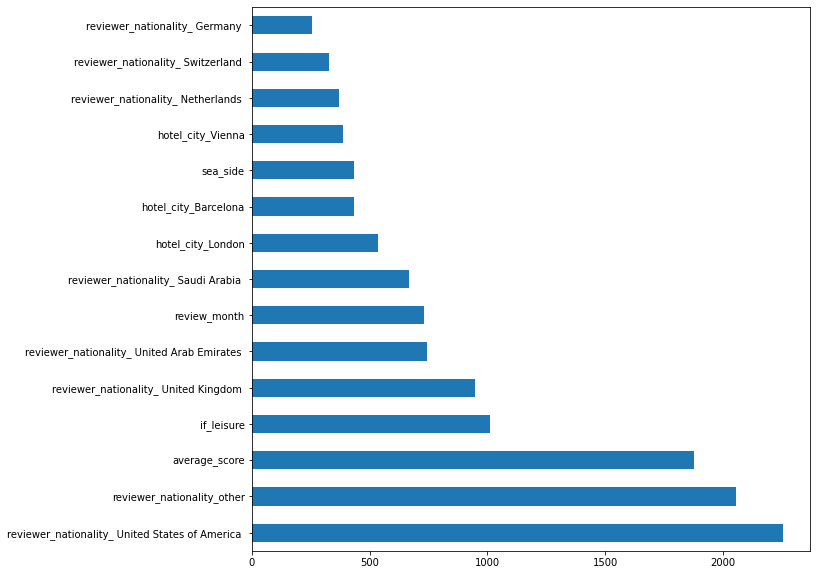

In [69]:
y_int=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

plt.rcParams['figure.figsize'] = (10,10)
imp_cat = pd.Series(chi2(X[cat_cols], y_int)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.nlargest(15).plot(kind = 'barh')

<AxesSubplot:>

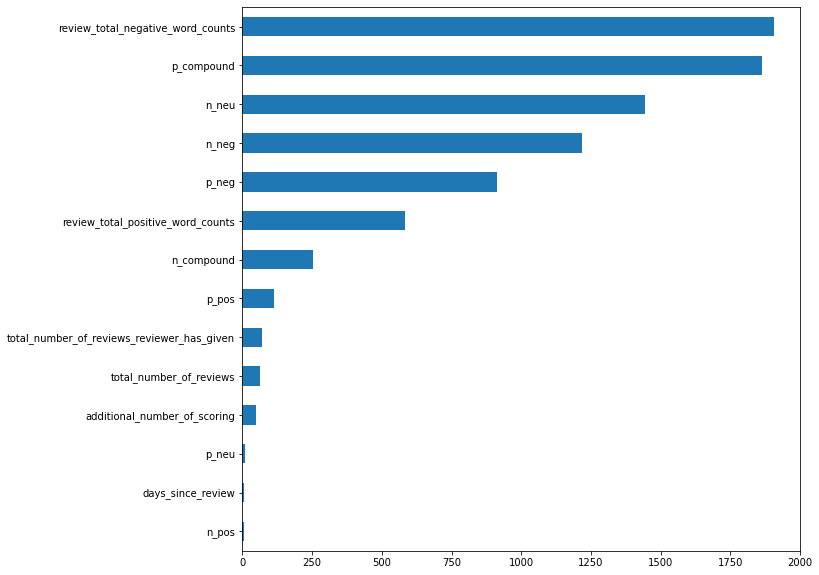

In [70]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Проанализируем мультиколлинеарность

<AxesSubplot:>

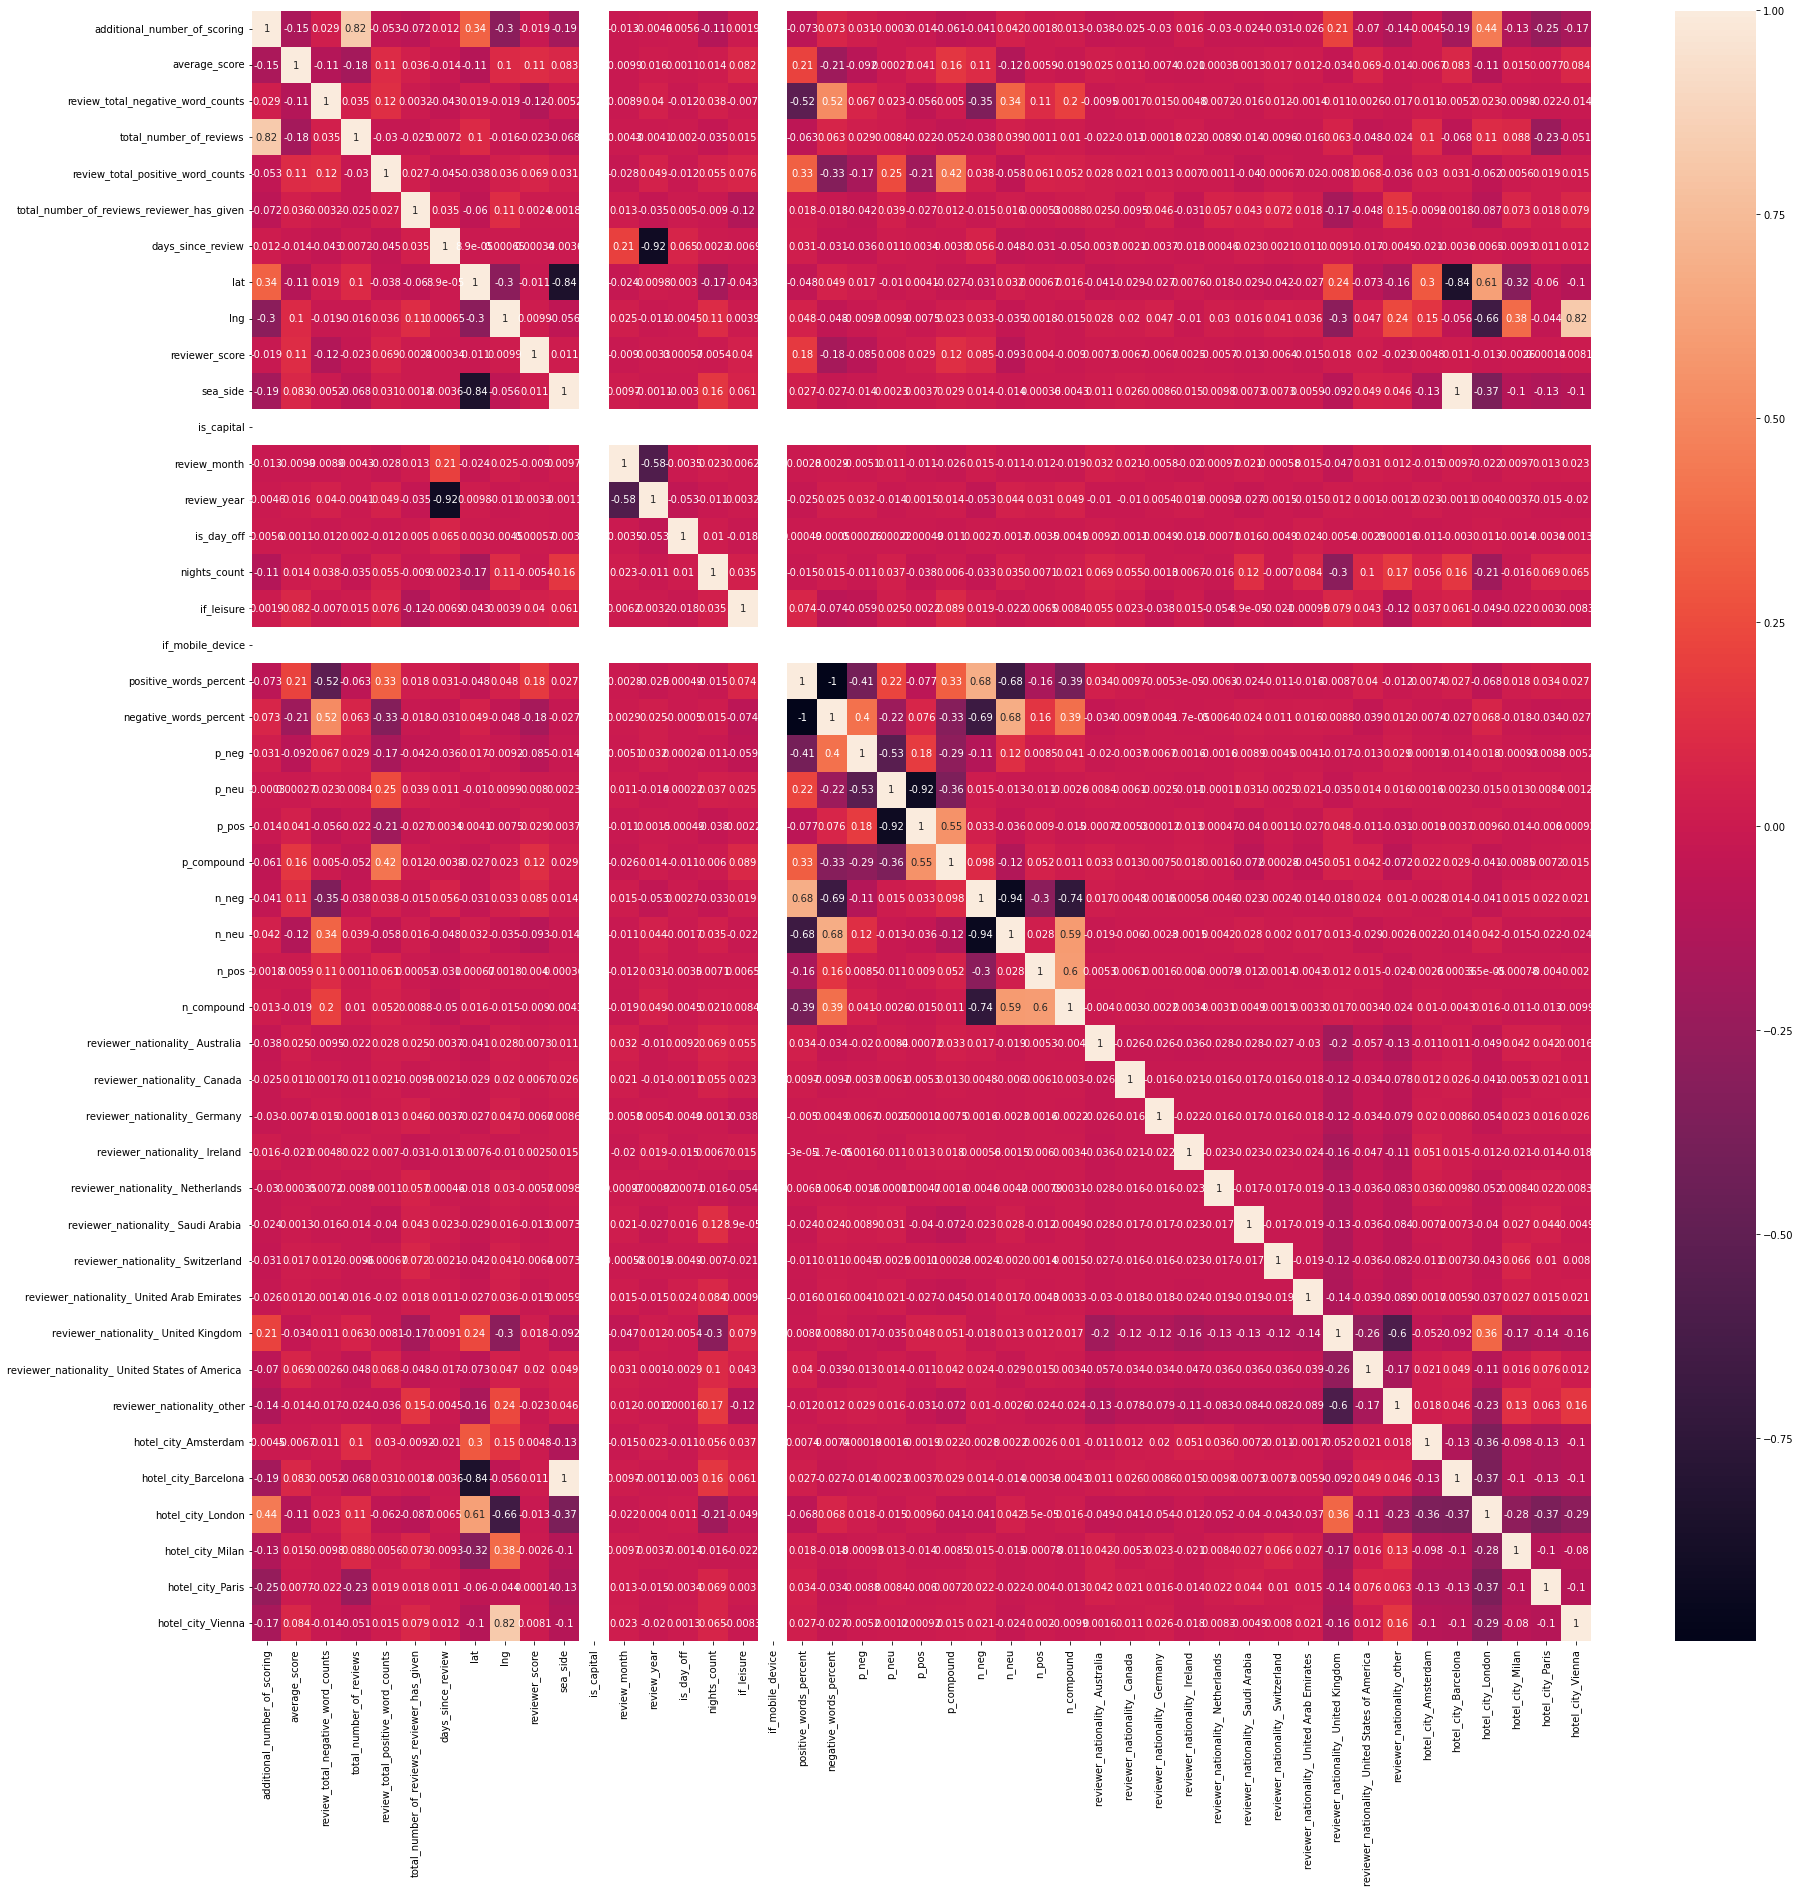

In [71]:
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(df.drop(['sample'], axis=1).corr(), annot=True)

In [72]:
# Удаляем признаки с высокой корреляцией
corr_matrix = df.drop(['sample'], axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
display(to_drop)

df.drop(to_drop, axis=1, inplace=True)

['negative_words_percent', 'hotel_city_Barcelona']

<AxesSubplot:>

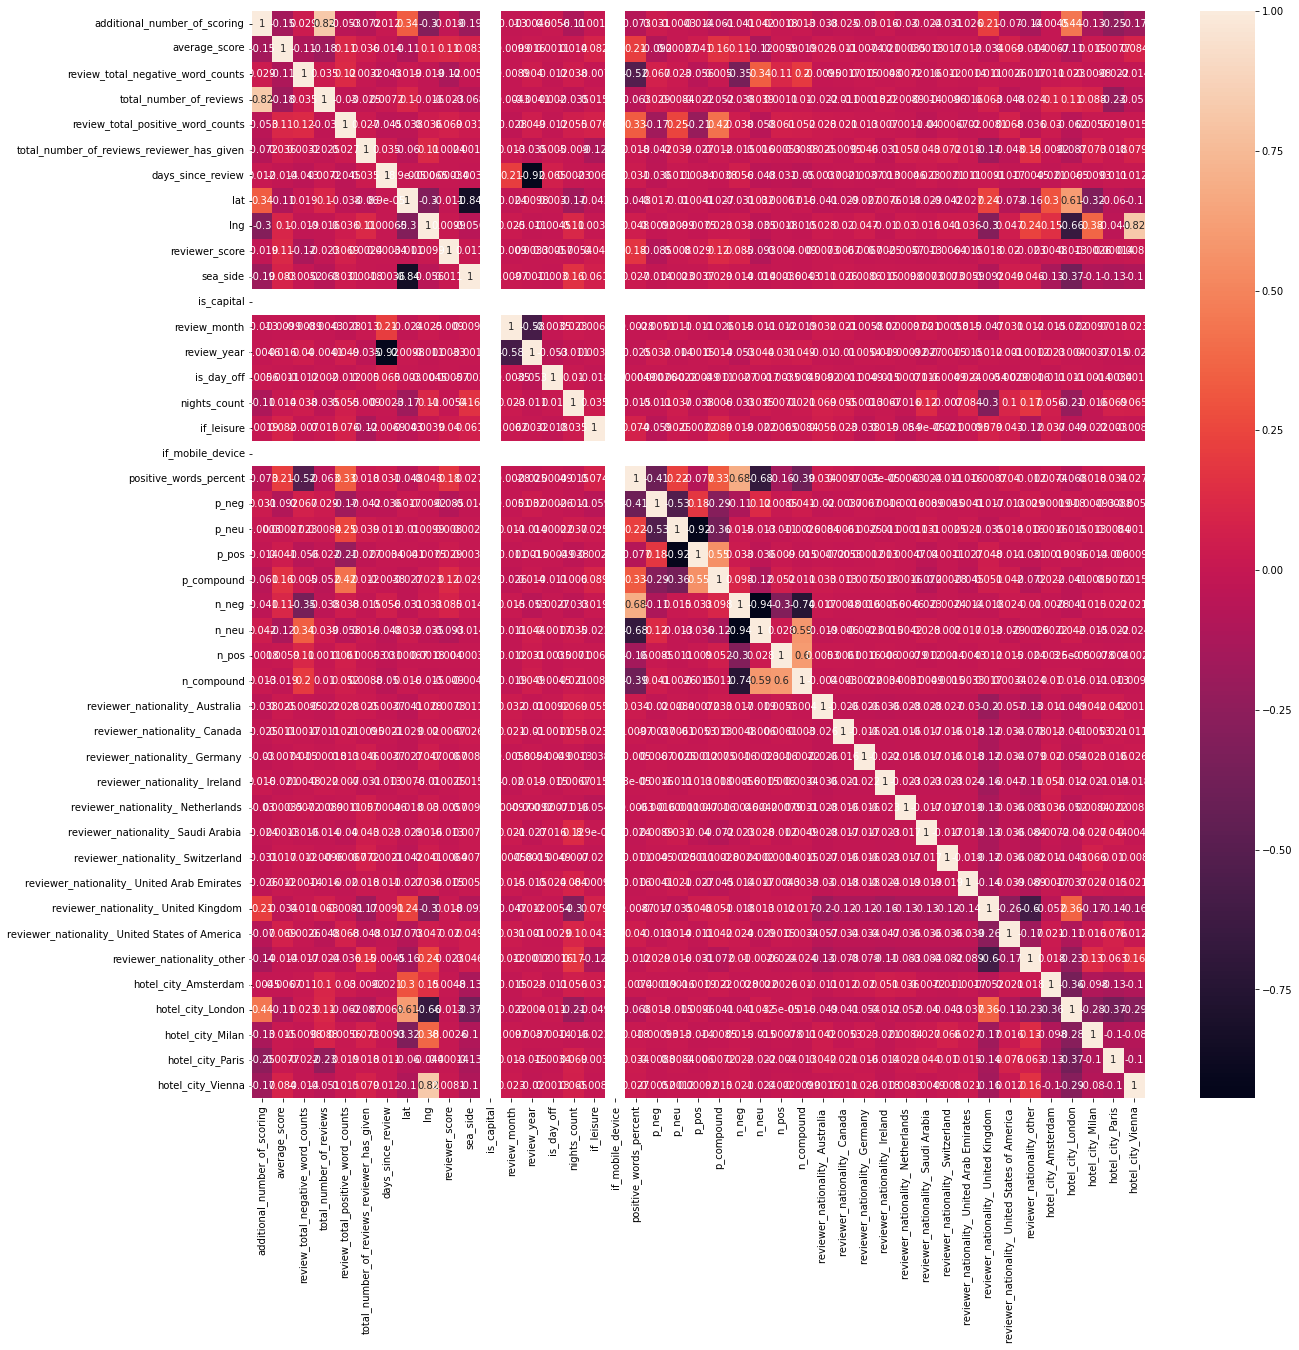

In [73]:
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(df.drop(['sample'], axis=1).corr(), annot=True)

In [74]:
df = df.drop(['is_capital','if_mobile_device','n_neu', 'p_neu', 'n_neg', 'additional_number_of_scoring', 'review_year'], axis = 1, inplace=True) 

### Подготовим модель.

In [75]:
train_data = df_r.query('sample == 1').drop(['sample'], axis=1)
test_data = df_r.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis=1)
y = train_data.reviewer_score.values

# разделяем тренинговый датасет: 80% на обучение, 20% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем размерности получившихся датасетов
train_data.shape, test_data.shape, X.shape, X_train.shape, X_test.shape

# создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train) 

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s


MAPE: 0.1255102942250021


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.3s finished


<AxesSubplot:>

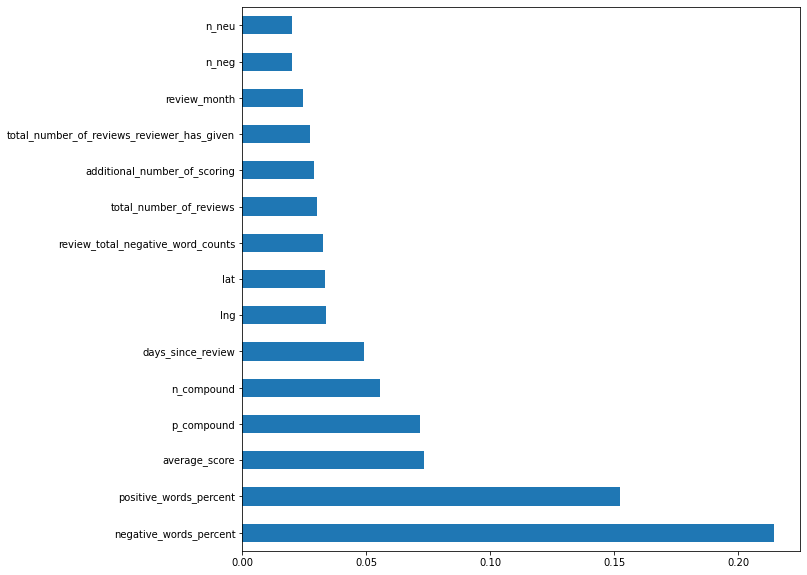

In [76]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [77]:
test_data = test_data.drop(['reviewer_score'], axis=1)

sample_submission.head(2)

,reviewer_score,id
0,8.531,488440
1,7.139,274649


In [78]:
predict_submission = regr.predict(test_data)
predict_submission

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.3s finished


array([8.531, 7.139, 8.284, ..., 8.194, 9.517, 7.398])

In [79]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.531,488440
1,7.139,274649
2,8.284,374688
3,9.672,404352
4,9.653,451596
5,9.054,302161
6,7.657,317079
7,7.697,13963
8,8.705,159785
9,7.277,195089


конец